# Análise da Perda de Funcionário

In [2]:
# Bibliotecas de Sistema
import glob
import os
from zipfile import ZipFile
from copy import deepcopy
from pathlib import Path
from abc import ABC, abstractmethod
from __future__ import annotations
from typing import Dict, List, Tuple, Any
import warnings

# Manipulação de Dados
import pandas as pd
import numpy as np


#  Estatística
from scipy.stats import kendalltau
from statsmodels.stats.weightstats import ztest
from scipy.stats import chisquare

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

# Processamento
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from feature_engine.encoding import OneHotEncoder, CountFrequencyEncoder


# Balanceamento
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek


# Modelo
## Métricas de Validação
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

## Validação Cruzada e GridSearch
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

## Modelo em Árvore
import lightgbm as lgb





# Configurações Globais

warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_theme(style='darkgrid')
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Funcionalidades Implementadas

In [3]:
def binary_cumulative(data_frame: pd.DataFrame, variavel_explicativa: str,
 variavel_alvo: str, sorted: bool = False) -> Dict[Any, List]:
  
  """
  Função que calcula, para uma variável alvo binária, a quantidade de ocorrências de \n
  cada valor da variável alvo, em cada valor da variável explicativa.


  Parametros
  ----------
  data_frame : pd.DataFrame
      DataFrame com as variáveis explicativas e alvo.
  variavel_explicativa : str
      Nome da variável explicativa.
  variavel_alvo : str
      Nome da variável alvo.
  sorted : bool, optional
      Se True, retorna uma lista ordenada.
  
  Retorno
  -------
  Retorna um dicionário com as ocorrências dos valores da variável alvo \n
  para cada valor da variável explicativa.

  Exemplo
  -------
  >>> binary_cumulative(data_frame, "Attrition", "YearsWithCurrManager")
  >>> {5: [27, 4],
  >>> 7: [185, 31],
  >>> 0: [178, 85],
  >>> 2: [294, 50],
  >>> 6: [25, 4],
  >>> 8: [97, 10],
  >>> 3: [123, 19],
  >>> 11: [21, 1],
  >>> 17: [7, 0],
  >>> 1: [65, 11],
  >>> 4: [87, 11],
  >>> 12: [18, 0],
  >>> 9: [58, 6],
  >>> 10: [24, 3],
  >>> 15: [5, 0],
  >>> 13: [14, 0],
  >>> 16: [2, 0],
  >>> 14: [3, 2]}

  """


  # ------------------------------------------------------------ #
  
  # Inicializando o dicionário que armazenará os resultados
  dict_result = {}

  # ------------------------------------------------------------ #

  # Armazenando em um array os valores únicos da variavel explicativa
  if sorted:
    data_feature_unique_values = np.sort(data_frame[variavel_explicativa].unique())
  else:
    data_feature_unique_values = data_frame[variavel_explicativa].unique()

  # ------------------------------------------------------------ #

  # Armazenando os valores únicos da variavel alvo
  binary_target = np.sort(data_frame[variavel_alvo].unique())

    # Criando uma tupla para abrigar os valores da variável alvo
  binary_values_target = (binary_target[0], binary_target[1])

  # ------------------------------------------------------------ #


  # Loop para calcular a ocorrência dos valores binários da variável alvo, em cada valor da variável explicativa

  for i in data_feature_unique_values:
    dict_result[i] = [data_frame.loc[(data_frame[variavel_alvo]==binary_values_target[0]) & (data_frame[variavel_explicativa]==i)].__len__(),
                      data_frame.loc[(data_frame[variavel_alvo]==binary_values_target[1]) & (data_frame[variavel_explicativa]==i)].__len__()] 

  # ------------------------------------------------------------ #

  # Retornando um dicionário com os resultados {variável explicativa: (ocorrencias da variavel alvo 1, ocorrencias da variavel alvo 2)}
  return dict_result


def to_plot_cumulative(data_frame: pd.DataFrame, variavel_explicativa: str, 
variavel_alvo: str, index: int) -> Tuple[float]:
  """
  Função que gera dados prontos para plot, considerando o agregado dos valores binários\n
  para cada valor da variável explicativa.

    Parametros
    ----------
    data_frame : pd.DataFrame
        DataFrame com as variáveis explicativas e alvo.
    variavel_explicativa : str
        Nome da variável explicativa.
    variavel_alvo : str
        Nome da variável alvo.
    index : int
        Índice que específica qual valor da variável alvo a ser utilizado.

    Retorno
    -------
    list_key: float
        Lista com os valores da variável explicativa.
    list_value: float
        Lista com o valor cumulativo da variável alvo escolhida.


    Exemplo
    -------
    >>> to_plot_cumulative(data_frame, "Attrition", "YearsWithCurrManager", 0)
    >>> ([5, 7, 0, 2, 6, 8, 3, 11, 17, 1, 4, 12, 9, 10, 15, 13, 16, 14],
     [27, 185, 178, 294, 25, 97, 123, 21, 65, 87, 58, 24, 5, 14, 2, 3, 0, 0, 0])
  """


  # ------------------------------------------------------------ #

  # Iniciando as listas que serão utilizadas para armazenar os dados
  list_key = []
  list_values = []

  # ------------------------------------------------------------ #

  # Gerando o dicionário com os resultados da função binary_cumulative
  dict_result = binary_cumulative(data_frame, variavel_explicativa, variavel_alvo)

  # ------------------------------------------------------------ #

  # Loop para desempacotar o dicionário de resultados
  for i, j in zip(dict_result.keys(), dict_result.values()):
    list_key.append(i)
    list_values.append(j[index])


  # ------------------------------------------------------------ #

  # Retornando uma tupla com os dados prontos para plot
  return list_key, list_values


def get_proportion(data_frame: pd.DataFrame, variavel_explicativa: str,
  variavel_alvo: str) -> List[float]:
  """
  Obtém a proporção de ocorrências de cada valor da variável alvo\n
  para cada valor da variável explicativa.
  """

  # ------------------------------------------------------------ #

  proportion_list = []
  x_0, y_0 = to_plot_cumulative(data_frame, variavel_explicativa, variavel_alvo, 0)
  x_1, y_1 = to_plot_cumulative(data_frame, variavel_explicativa, variavel_alvo, 1)

  # ------------------------------------------------------------ #

  
  proportion_list = [y1/y0 for y0,y1 in zip(y_0, y_1) if y0 != 0]

  return proportion_list




def get_correlation_time(data_frame: pd.DataFrame, variavel_explicativa: str,
variavel_alvo: str) -> Tuple[float]:
  """
  Para variáveis que variam com o tempo, indica se a variável alvo possui\n
  correlação com a variável no tempo. Retorna uma lista com o coeficiente de\n
  correlação e o p-valor de Kendall.

    Parametros
    ----------
    - data_frame: DataFrame com os dados.
    - variavel_explicativa: Variável explicativa.\n
    - variavel_alvo: Variável alvo.\n

    Retorno
    -------
    - Coeficiente de correlação de Kendall: float \n
    - p-valor de Kendall: float \n

    Exemplo
    -------
    >>> get_correlation_time(data, "YearsWithCurrManager", "Attrition")
    >>> (0.948, 0.0012)
  """

  # ------------------------------------------------------------ #

  proportion_list = get_proportion(data_frame, variavel_explicativa, variavel_alvo)
  coef, p_value = kendalltau(proportion_list, [x for x in range(len(proportion_list))])

  # ------------------------------------------------------------ #

  return coef, p_value



def test_null_result(data_frame: pd.DataFrame, variavel_explicativa: str, variavel_alvo: str) -> None:
  """
  Considerando que a hipótese nula é que a passagem do tempo não influência linearmente\n
  a variável alvo. Gera um resultado no console indicando se a hipótese nula\n
  foi aceita ou não.
    Parametros
    ----------
    - data_frame: DataFrame com os dados.
    - variavel_explicativa: Variável explicativa.\n
    - variavel_alvo: Variável alvo.\n

    Retorno
    -------
    - Realiza o teste e indica se a hipótese nula foi aceita ou não.

  """

  # ------------------------------------------------------------ #

  coef, p_valor = get_correlation_time(data_frame, variavel_explicativa, variavel_alvo)

  if (p_valor > 0.05) or (coef == 0.0):
    print(
    f"Considerando {variavel_explicativa}, a passagem do tempo não influencia no Attrition. \n nível de significância: 5% \n p-valor: {round(p_valor, 4)}"
    )

  else:
    if coef>0:
      print(f"Considerando {variavel_explicativa}, a passagem do tempo aumenta as chances do empregado abandonar a empresa com nível de significância de 5%. \n Coeficiente de correlação: {round(coef, 4)} \n p-valor: {round(p_valor, 4)}")
    
    elif coef<0:
      print(f"Considerando {variavel_explicativa}, a passagem do tempo diminui as chances do empregado abandonar a empresa com nível de significância de 5%. \n Coeficiente de correlação: {round(coef, 4)} \n p-valor: {round(p_valor, 4)}")


  

## 2. Baixando os Dados Utilizando a API do Kaggle

In [4]:
# Instalando a API do Kaggle
# !pip install kaggle --upgrade

In [5]:
!kaggle datasets download -d pavansubhasht/ibm-hr-analytics-attrition-dataset

'kaggle' nao � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


Lidando com o dado de resultado da API do Kaggle. Podemos observar, primeiramente, que o arquivo vem zipado, portanto, teremos que descompactá-lo para depois trabalhar com ele

In [6]:
# Importando todos os arquivos zip do diretório
zip_files = glob.glob('*.zip')
zip_files

['ibm-hr-analytics-attrition-dataset.zip']

In [7]:
try:
    for file in zip_files:
        with ZipFile(file, 'r') as zip_file:
            zip_file.extractall()
            n = 0
            for file in zip_file.namelist():
                if file.endswith('.csv'):
                    n += 1
                    os.rename(file, f'attrition_data{n}.csv')                
            zip_file.close()
except:
    pass

In [8]:
z = ZipFile('ibm-hr-analytics-attrition-dataset.zip')
z.namelist()

['WA_Fn-UseC_-HR-Employee-Attrition.csv']

## 3. Análise Exploratória de Dados

In [9]:
data = pd.read_csv("attrition_data1.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

Das informações acima, podemos observar que a base de dados não possui colunas com valores nulos. Portanto, seguimos investigando alguns atributos

In [10]:
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


Temos que a variável alvo "Attrition" está descrita de maneira categórica, algo que podemos modificar para que esta possa ser melhor abordada no futuro. Para isso, façamos a seguinte substituição: No -> 0, Yes -> 1

In [11]:
data_copy = deepcopy(data)
data_copy.loc[data_copy["Attrition"] == "Yes", "Attrition"] = 1
data_copy.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [12]:
data.loc[data["Attrition"]=="Yes", "Attrition"] = 1
data.loc[data["Attrition"] == "No", "Attrition"] = 0
data[["Attrition"]] = data[["Attrition"]].astype("int")

Isso poderá nos auxiliar a construir relações quantitativas melhores entre a variável alvo e as variáveis dependentes. Como podemos ver, há também um alto número de colunas na base de dados. Talvez um ponto interessante para que possamos reduzir essa quantidade de colunas é realizando uma feature importance

In [13]:
# Separando a variável alvo das variáveis dependentes
    # Variáveis dependentes
x_feature_importance = data.drop(columns="Attrition").select_dtypes(include=np.number)

x_features_names = x_feature_importance.columns

y_feature_importance = data[["Attrition"]]

In [14]:
# Dividindo a base de dados
x_train, x_test, y_train, y_test = train_test_split(x_feature_importance,
                                                    y_feature_importance,
                                                   test_size=0.3,
                                                   random_state=13)

In [15]:
x_train.to_numpy().shape, y_train.to_numpy().reshape(1,-1).shape

((1029, 26), (1, 1029))

c:\Users\Lucas\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Lucas\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


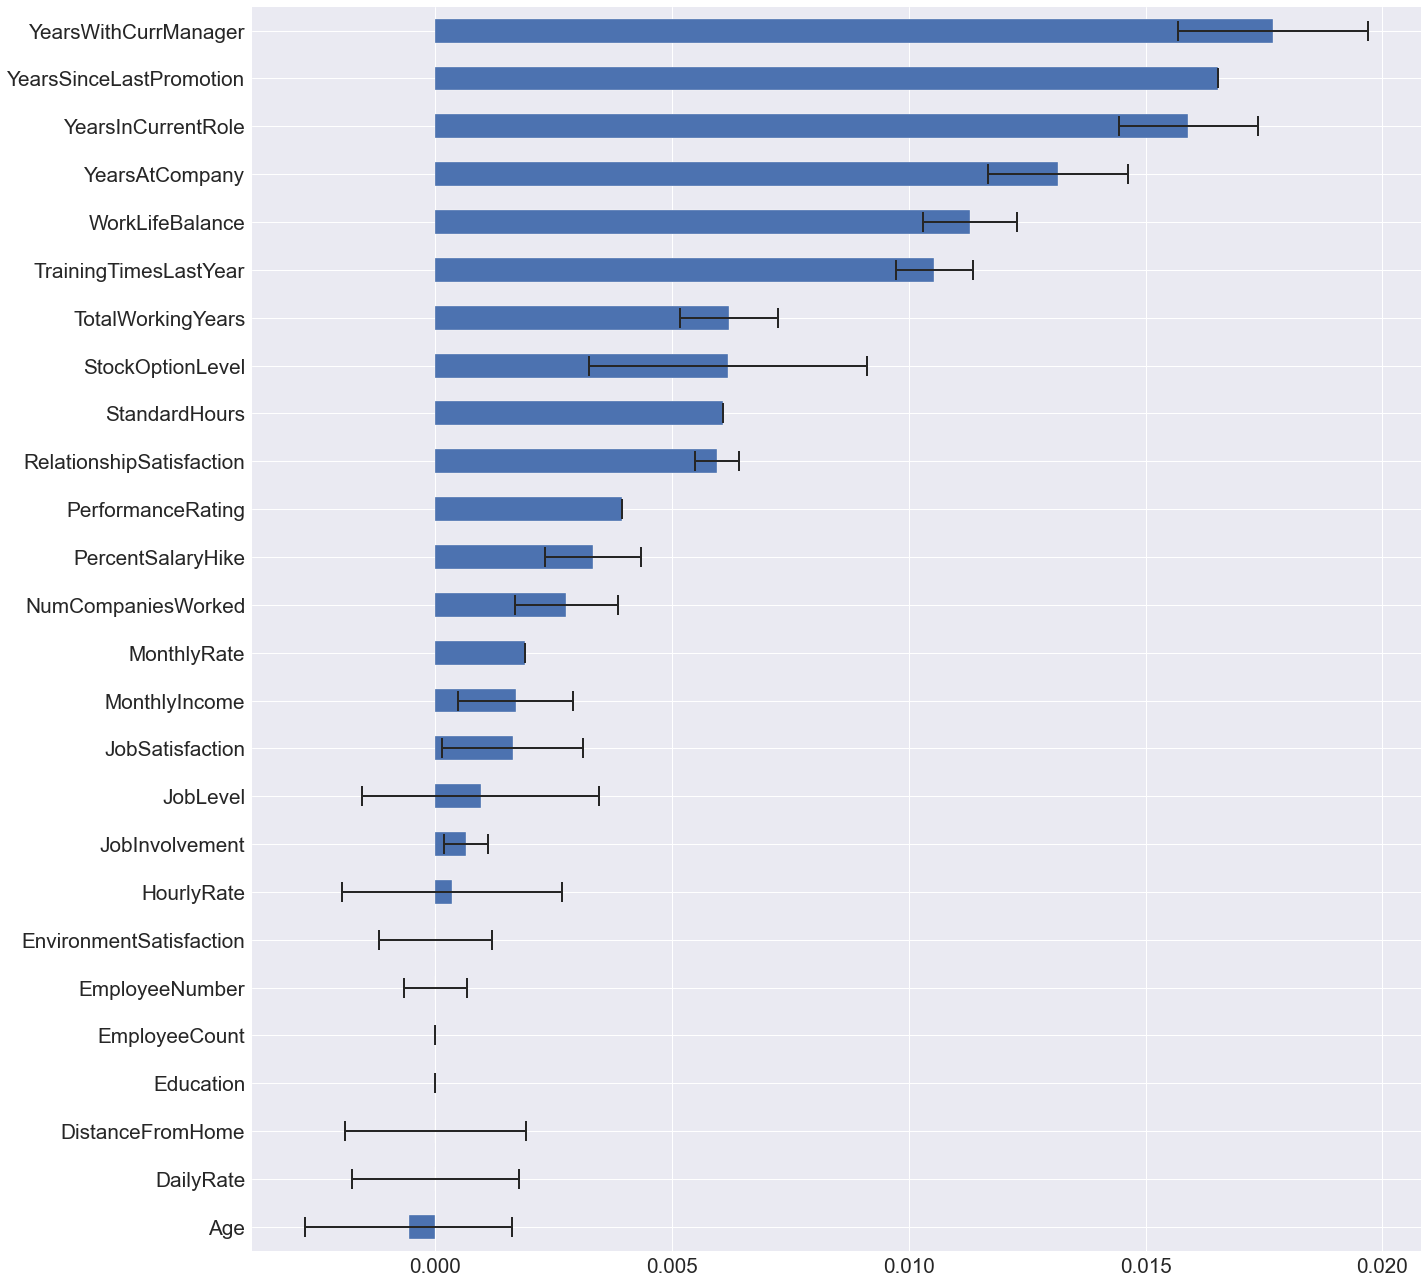

In [16]:
lgbm_importance = lgb.LGBMClassifier(n_estimators=100, 
learning_rate=0.01, random_state=13, n_jobs=-1,)
lgbm_importance.fit(x_train, y_train)
importances = lgbm_importance.feature_importances_

importances = permutation_importance(lgbm_importance, x_train, y_train, 
n_repeats=50, random_state=13, n_jobs=-1)


importance_to_plot = list(importances.importances_mean)
importance_to_plot.sort()
features_importance = pd.Series(importance_to_plot, index=x_features_names)


fig, ax = plt.subplots(figsize=(20,18))
features_importance.plot.barh(xerr=importances.importances_std, ax=ax,
                             error_kw={'elinewidth': 2, 'capsize': 10, 'capthick': 2})
ax.tick_params(labelsize='xx-large')
fig.tight_layout()
plt.show()

Esta análise, apesar de tomar apenas dados numéricos, excluindo os categóricos, possibilita que entendemos quais categóricos possivelmente podem ser utilizados para melhorar a análise.

Mas antes de partimos para a análise de dados categóricos, faremos um estudo mais aproximado sobre as variáveis acima. 

### 3.1. Variáveis Numéricas

#### Um olhar sobre as variáveis mais improtantes

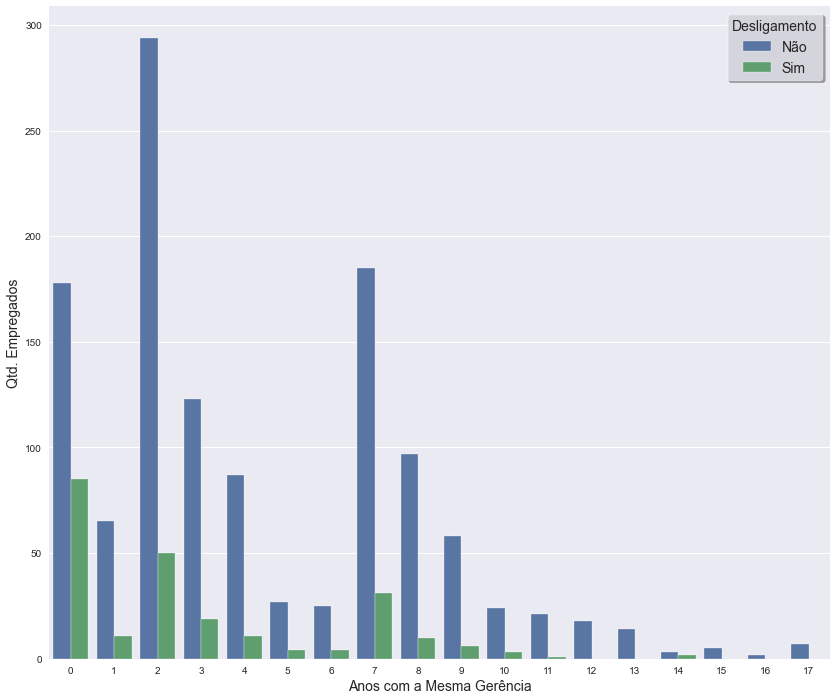

In [17]:
figs, axs = plt.subplots(figsize=(14,12), nrows=1, ncols=1, squeeze=False)
sns.countplot(x=data.YearsWithCurrManager, hue=data.Attrition)
plt.xlabel('Anos com a Mesma Gerência', fontsize=14) 
plt.ylabel('Qtd. Empregados', fontsize=14)
plt.legend(["Não", "Sim"], loc='upper right', fontsize=14, title='Desligamento', title_fontsize=14, 
frameon=True, framealpha=0.75, edgecolor='white', fancybox=True, shadow=True)
plt.show()

No gráfico de barras acima, é construída a relação entre a variável número de anos com o atual gerente e a variável alvo.  Podemos verificar melhor essa relação plotando a densidade de funcionários perdidos pelo número de anos com o atual gerente.

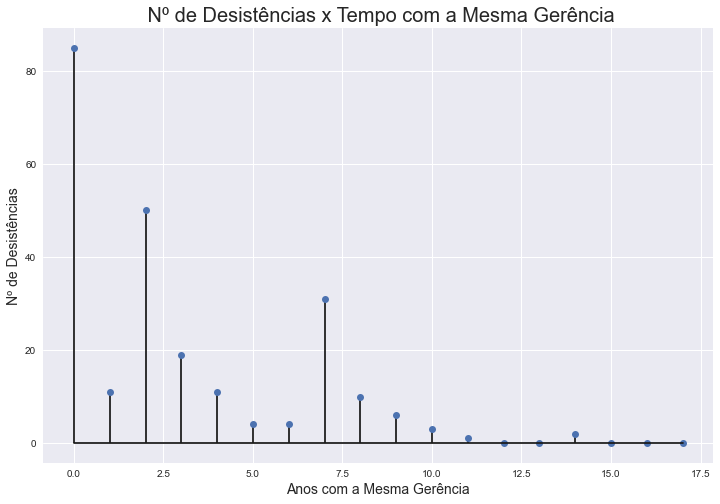

In [18]:
x, y  = to_plot_cumulative(data, "YearsWithCurrManager", "Attrition", 1)
plt.stem(x, y, markerfmt='bo', basefmt='k-', linefmt='k-')
plt.title(" Nº de Desistências x Tempo com a Mesma Gerência", fontsize=20)
plt.xlabel("Anos com a Mesma Gerência", fontsize=14)
plt.ylabel("Nº de Desistências", fontsize=14)
plt.show()

O gráfico acima pode indicar que a troca de gerência pode ocasionar em uma tendência de perda de funcionários e até uma predileção dos funcionários por ambientes de maior estabilidade. Pois tenha vista que a troca de uma gerência pode impactar muito no dia-a-dia dos funcionários de uma empresa. Logo, se uma empresa troca de gerência muitas vezes, pode se esperar que o ambiente de trabalho seja mais instável, com mais mudanças de estruturação.

Podemos investigar outros atributos que podem informar um pouco mais sobre essa tendência. Por exmeplo, podemos verificar como os anos na empresa são correlacionados com a quantidade de funcionários perdidos.

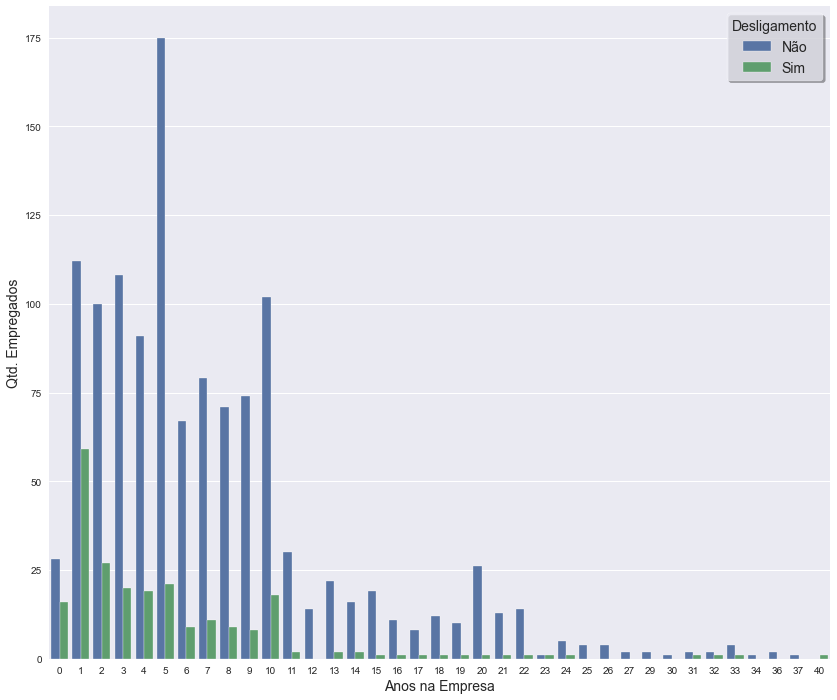

In [19]:
figs, axs = plt.subplots(figsize=(14,12), nrows=1, ncols=1, squeeze=False)
sns.countplot(x=data.YearsAtCompany, hue=data.Attrition)
plt.xlabel('Anos na Empresa', fontsize=14) 
plt.ylabel('Qtd. Empregados', fontsize=14)
plt.legend(["Não", "Sim"], loc='upper right', fontsize=14, title='Desligamento', title_fontsize=14, 
frameon=True, framealpha=0.75, edgecolor='white', fancybox=True, shadow=True)
plt.show()

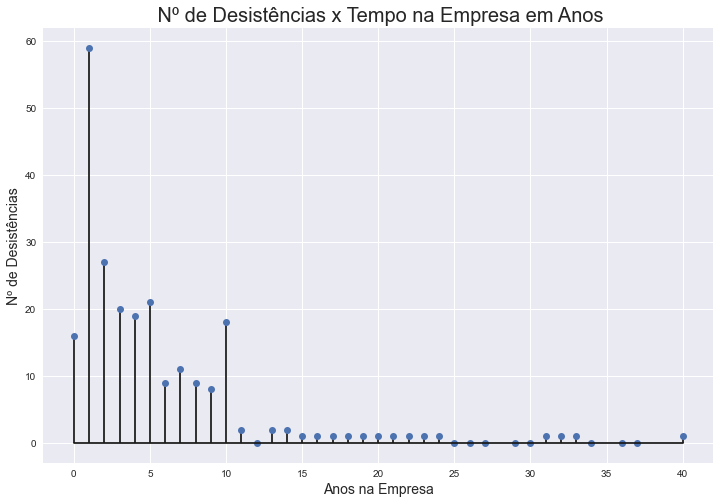

In [20]:
x, y  = to_plot_cumulative(data, "YearsAtCompany", "Attrition", 1)
plt.stem(x, y, markerfmt='bo', basefmt='k-', linefmt='k-')
plt.title(" Nº de Desistências x Tempo na Empresa em Anos", fontsize=20)
plt.xlabel("Anos na Empresa", fontsize=14)
plt.ylabel("Nº de Desistências", fontsize=14)
plt.show()

E também os anos desde a última promoção que o empregado recebeu.

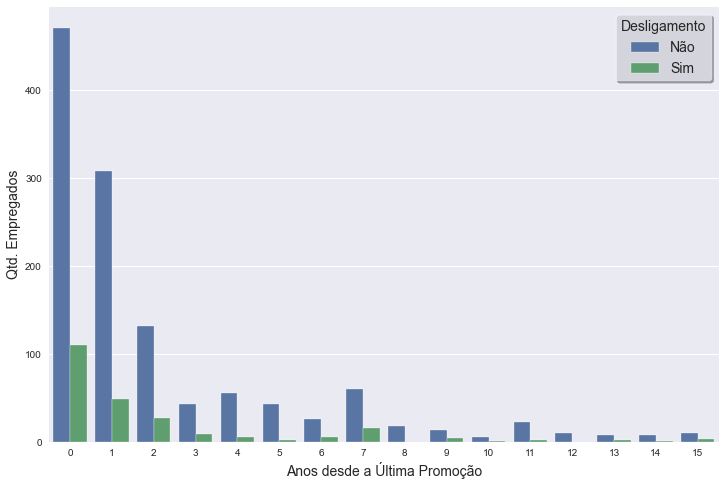

In [21]:
# figs, axs = plt.subplots(figsize=(14,12), nrows=1, ncols=1, squeeze=False)
sns.countplot(x=data.YearsSinceLastPromotion, hue=data.Attrition)
plt.xlabel('Anos desde a Última Promoção', fontsize=14) 
plt.ylabel('Qtd. Empregados', fontsize=14)
plt.legend(["Não", "Sim"], loc='upper right', fontsize=14, title='Desligamento', title_fontsize=14, 
frameon=True, framealpha=0.75, edgecolor='white', fancybox=True, shadow=True)
plt.show()

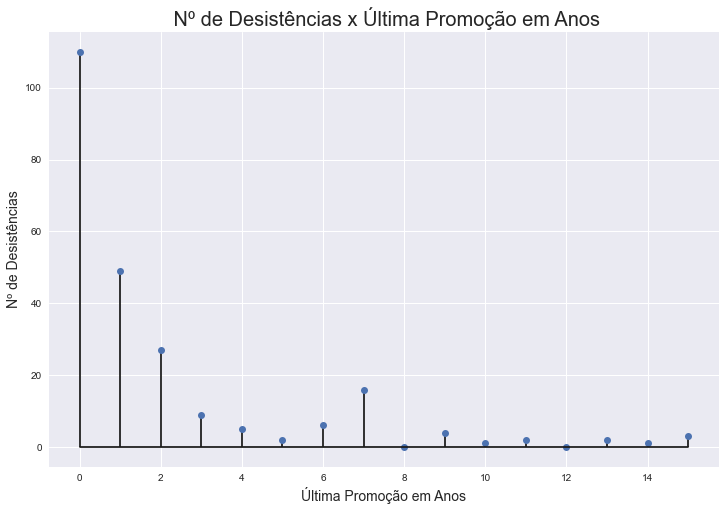

In [22]:
x, y  = to_plot_cumulative(data, "YearsSinceLastPromotion", "Attrition", 1)
plt.stem(x, y, markerfmt='bo', basefmt='k-', linefmt='k-')
plt.title(" Nº de Desistências x Última Promoção em Anos", fontsize=20)
plt.xlabel("Última Promoção em Anos", fontsize=14)
plt.ylabel("Nº de Desistências", fontsize=14)
plt.show()

Sendo esse último bastante contraintuitivo, pois esses dados poderiam levar à conclusão de que promover um funcionário aumentariam as chances desse abandonar a empresa. Porém, devemos fazer essa análise com bastante cautela. Isso porque podemos verificar que a distribuição de funcionários nesses atributos já seguem uma distribuição de cauda-longa, independentemente se ocorreu o *attrition* ou não. 

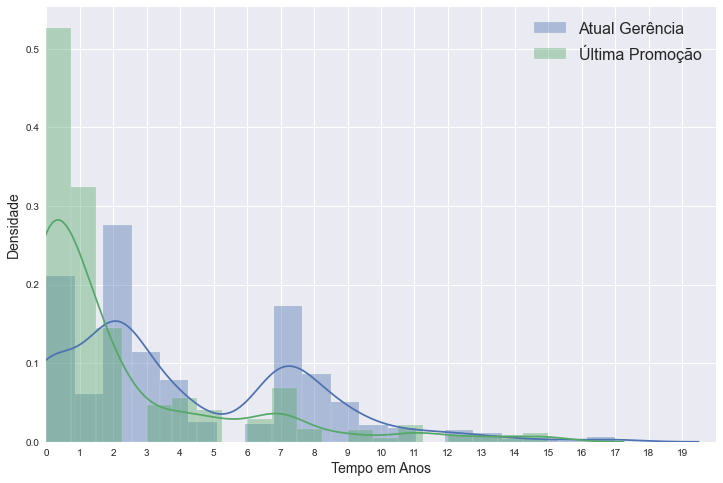

In [23]:
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,8))
sns.distplot(data.YearsWithCurrManager, bins=20, kde=True, label='Atual Gerência')
sns.distplot(data.YearsSinceLastPromotion, bins=20, kde=True, label='Última Promoção')
ticks_x = np.arange(0, 20, 1)
plt.xticks(ticks_x)
plt.xlim(0, 20)
plt.xlabel('Tempo em Anos', fontsize=14)
plt.ylabel('Densidade', fontsize=14)
plt.legend(fontsize=16)
plt.show()

Como pensado, a distribuição vai afunilando com o passar dos anos. Portanto, devemos verificar se a nossa hipótese tem consistência estatística para ser afirmada.

In [24]:
get_proportion(data, "YearsWithCurrManager", "Attrition")

[0.14814814814814814,
 0.16756756756756758,
 0.47752808988764045,
 0.17006802721088435,
 0.16,
 0.10309278350515463,
 0.15447154471544716,
 0.047619047619047616,
 0.0,
 0.16923076923076924,
 0.12643678160919541,
 0.0,
 0.10344827586206896,
 0.125,
 0.0,
 0.0,
 0.0,
 0.6666666666666666]

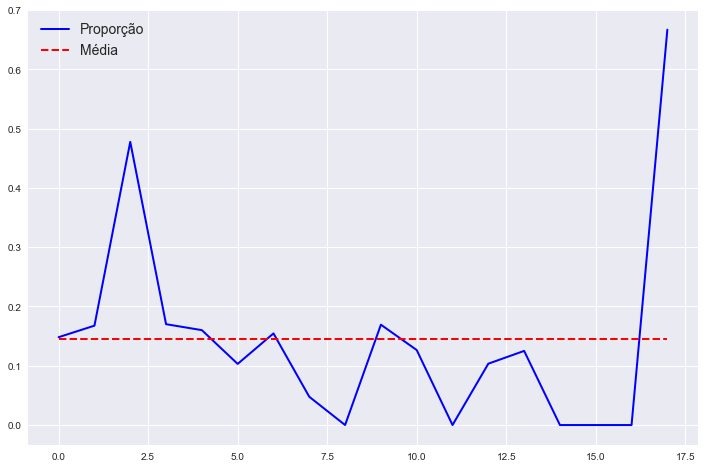

In [25]:
list_plot = get_proportion(data, "YearsWithCurrManager", "Attrition")

mean_plot = [np.mean(list_plot) for x in range(len(list_plot))]

plt.plot(list_plot, color='blue', linewidth=2, label='Proporção')
plt.plot(mean_plot, color='red', linewidth=2, linestyle='--', label='Média')
plt.legend(loc='best', fontsize=14)
plt.show()

proportion = y1/y0
y0 -> attrition 0
y1 -> attrition 1


Se com a passagem do tempo a proportion aumenta, então significa que, pra um determinado atributo, quanto mais o tempo passa, maior as chances do funcionário abandonar a empresa.

Se com a passagem do tempo a proportion diminui, então significa que, pra um determinado atributo, quanto mais o temp opassa, menor as chances do funcionário abandonar a empresa.

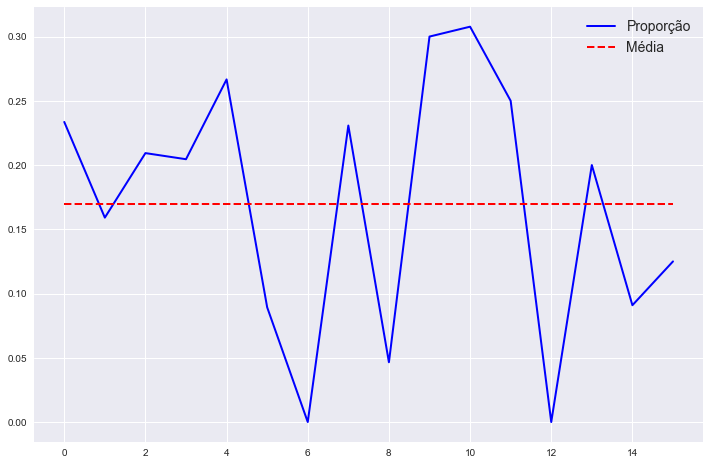

In [26]:
list_plot = get_proportion(data, "YearsSinceLastPromotion", "Attrition")

mean_plot = [np.mean(list_plot) for x in range(len(list_plot))]

plt.plot(list_plot, color='blue', linewidth=2, label='Proporção')
plt.plot(mean_plot, color='red', linewidth=2, linestyle='--', label='Média')
plt.legend(loc='best', fontsize=14)
plt.show()

In [27]:
coef, p = kendalltau(list_plot, [x for x in range(len(list_plot))])
print(f"O Coeficiente de Correlação de Kendall é: {coef}\n")
print(f"O p-value de Kendall é: {p}\n")

O Coeficiente de Correlação de Kendall é: -0.10878756313824399

O p-value de Kendall é: 0.557951571546442



A partir do p-valor calculado acima, podemos aceitar a hipótese nula de que os anos desde a última promoção não influenciam na perda de funcionários.

Com isso, podemos checar se há uma relação com as demais variáveis que possuem o mesmo perfil. Por exemplo, será se o tempo que o funcionário passa com o mesmo gerente influencia na permanência dele na empresa?

In [28]:
test_null_result(data, "YearsWithCurrManager", "Attrition")

Considerando YearsWithCurrManager, a passagem do tempo diminui as chances do empregado abandonar a empresa com nível de significância de 5%. 
 Coeficiente de correlação: -0.3718 
 p-valor: 0.035


Façamos também com o tempo desde a última promoção do empregado e também o tempo que o empregado está na empresa.

In [29]:
test_null_result(data, "YearsSinceLastPromotion", "Attrition")

print()
print("#" + 90*"-" + "#")
print()

test_null_result(data, "YearsAtCompany", "Attrition")

Considerando YearsSinceLastPromotion, a passagem do tempo não influencia no Attrition. 
 nível de significância: 5% 
 p-valor: 0.558

#------------------------------------------------------------------------------------------#

Considerando YearsAtCompany, a passagem do tempo não influencia no Attrition. 
 nível de significância: 5% 
 p-valor: 0.0527


Como podemos ver, entre os casos que visualizamos rapidamente, apenas o tempo que o funcionário passa com o mesmo gerente influencia de maneira progressiva se o funcionário irá continuar ou abandonar a empresa. Ou seja, se você pretende trocar o gerente da sua empresa, caso nenhuma política de contenção seja criada, você deve esperar um aumento na taxa de attrition nos dois anos, como podemos verificar no gráfico abaixo.

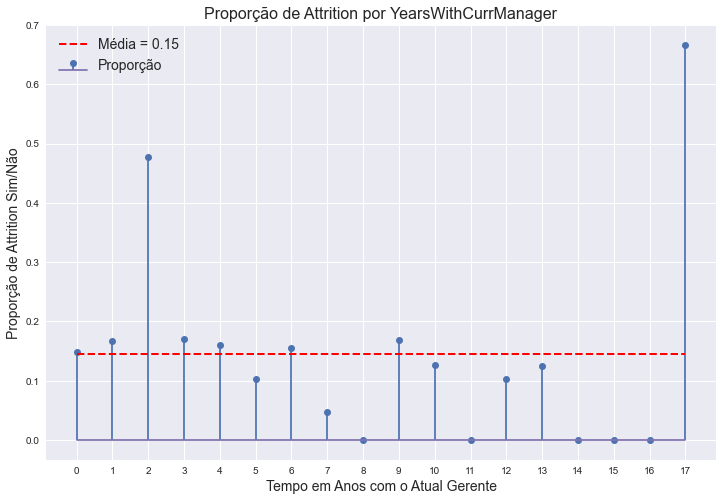

In [30]:
# Dados

list_plot = get_proportion(data, "YearsWithCurrManager", "Attrition")
mean_plot = [np.mean(list_plot) for x in range(len(list_plot))]
xticks = [x for x in range(len(list_plot))]


# Plot

plt.stem(list_plot, label='Proporção')
plt.plot(mean_plot, color='red', linewidth=2, linestyle='--', label=f'Média = {round(mean_plot[0], 2)}')

plt.xticks(xticks)
plt.ylabel("Proporção de Attrition Sim/Não", fontsize=14)
plt.xlabel('Tempo em Anos com o Atual Gerente', fontsize=14)

plt.legend(loc='best', fontsize=14)
plt.title("Proporção de Attrition por YearsWithCurrManager", fontsize=16)

plt.show()

Outro ponto que pode ser observado dos resultados acima é que podemos combinar as variáveis YearsAtCompany com as demais variáveis que descrevem alguma característica ao longo dos anos do empregado, como por exemplo, se combinarmos YearsAtCompany com YearsWithCurrManager, podemos verificar se aquele empregado já presenciou a mudança de gerente pelo menos uma vez ao longo do seu tempo na empresa. 

In [31]:
data_copy = deepcopy(data)
data_copy[["YearsAtCompany", "YearsWithCurrManager", "Attrition"]]

,YearsAtCompany,YearsWithCurrManager,Attrition
0,6,5,1
1,10,7,0
2,0,0,1
3,8,0,0
4,2,2,0
...,...,...,...
1465,5,3,0
1466,7,7,0
1467,6,3,0
1468,9,8,0


A construção do novo atributo ocorrerá ao comparar os anos na empresa com os anos com o atual gerente. Caso o número de anos seja o mesmo, saberemos que o empregado nunca presenciou a mudança de gerente, caso contrário, saberemos que o empregado já presenciou tal mudança.

In [32]:
data.loc[data_copy["YearsAtCompany"] == data["YearsWithCurrManager"], "WitnessedChangeManager"] = 0
data.loc[data["YearsAtCompany"] != data["YearsWithCurrManager"], "WitnessedChangeManager"] = 1
data = data.astype({"WitnessedChangeManager": int})

Agora vamos analisar como a nova variável está posta.

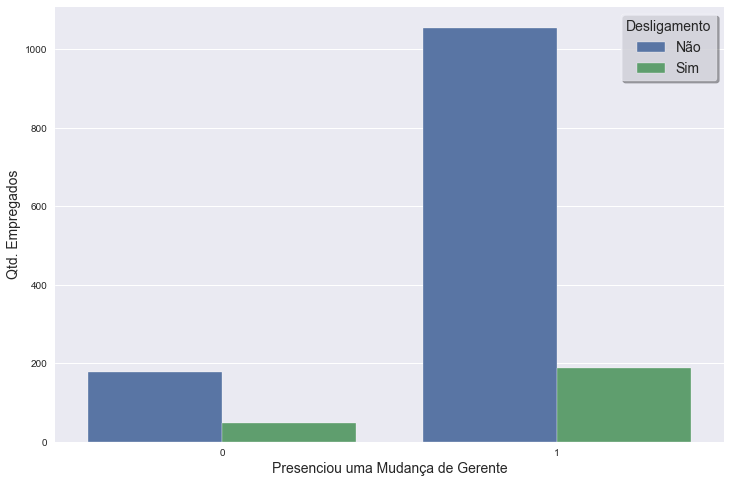

In [33]:
# figs, axs = plt.subplots(figsize=(14,12), nrows=1, ncols=1, squeeze=False)
sns.countplot(x=data.WitnessedChangeManager, hue=data.Attrition)
plt.xlabel('Presenciou uma Mudança de Gerente', fontsize=14) 
plt.ylabel('Qtd. Empregados', fontsize=14)
plt.legend(["Não", "Sim"], loc='upper right', fontsize=14, title='Desligamento', title_fontsize=14, 
frameon=True, framealpha=0.75, edgecolor='white', fancybox=True, shadow=True)
plt.show()

Podemos verificar como está a proporção de funcionários perdidos ou não, considerando se os funcionários passaram por um processo de mudança na gerência ou não.

In [34]:
nao_presenciou, presenciou = get_proportion(data, "WitnessedChangeManager", "Attrition")

print(f"A proporção de attrition de funcionários que presenciaram uma troca de gerência é: {round(presenciou, 2)}")
print(f"A proporção de attrition de funcionários que não presenciaram uma troca de gerência é: {round(nao_presenciou, 2)}")
print(f"A diferença da proporção entre os que presenciaram e não-presenciaram está na ordem de {round((presenciou-nao_presenciou)/presenciou*100, 2)}%")

A proporção de attrition de funcionários que presenciaram uma troca de gerência é: 0.27
A proporção de attrition de funcionários que não presenciaram uma troca de gerência é: 0.18
A diferença da proporção entre os que presenciaram e não-presenciaram está na ordem de 33.57%


Uma proporção maior, indica que houve uma quantidade maior de funcionários que se demitiram em uma amostra do que em outra. A proporção de funcionários que presenciaram a troca de gerência que abandonaram a empresa aumentou em 33.57% em relação aos que não-presenciaram.

A hipótese inicial indicava que os funcionários possuiam uma predileção por ambientes de maior estabilidade, portanto, qualquer mudança brusca na dinâmica de trabalho de um funcionário poderia aumentar as chances deste se desligar da empresa. Apesar da hipótese se mostrar infundada para algumas variáveis, como o tempo desde a última promoção do funcionário, ela apresentou robustez para a variável que indica o tempo que o funcionário se encontra com a atual gerência. Esse resultado nos permitiu a criação de um novo atributo, que se compromete em assimilar se um dado funcionário presenciou, no seu tempo de empresa, uma troca de gerência ou não, chegando a conclusão de que funcionários que presenciaram tal troca, possuem uma maior probabilidade de se desligarem da empresa.

Uma sugestão inicial que poderíamos realizar a partir da análise desses dados é de que caso seja necessária a troca da atual gerência, ou de alguma política que impacte consideravelmente a dinâmica da empresa, que um plano de contingência seja estabelecido de modo a reduzir o impacto da mudança e também novos planos de incentivo sejam discutidos durante o tempo de adaptação dos funcionários ao novo cenário.

#### Um olhar sobre as variáveis menos importantes

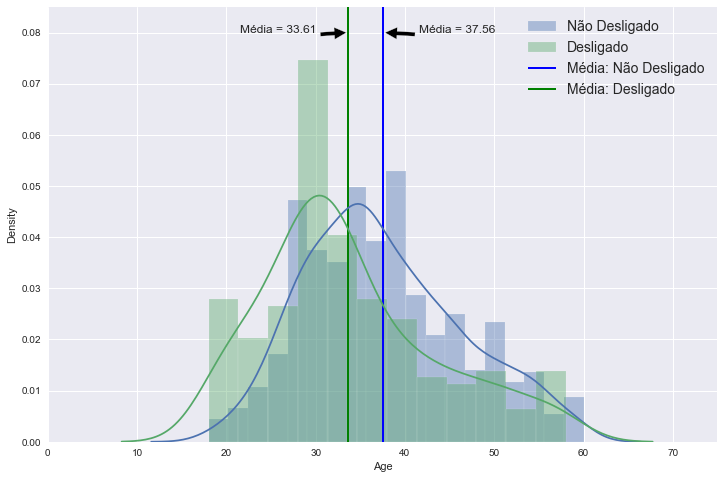

In [35]:
data_age_att_0 = data.loc[data["Attrition"] == 0, "Age"]
data_age_att_1 = data.loc[data["Attrition"] == 1, "Age"]
sns.distplot(data_age_att_0, kde=True, label="Não Desligado")
sns.distplot(data_age_att_1, kde=True, label="Desligado")
plt.vlines(x=data_age_att_0.mean(), ymin=0, ymax=0.09, linestyles='solid', linewidth=2, color='blue', label="Média: Não Desligado")
plt.vlines(x=data_age_att_1.mean(), ymin=0, ymax=0.09, linestyles='solid', linewidth=2, color='green', label="Média: Desligado")
plt.annotate(f"Média = {round(data_age_att_0.mean(), 2)}" , xy=(data_age_att_0.mean(), 0.08), xytext=(data_age_att_0.mean()+4, 0.08), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f"Média = {round(data_age_att_1.mean(), 2)}" , xy=(data_age_att_1.mean(), 0.08), xytext=(data_age_att_0.mean()-16, 0.08), arrowprops=dict(facecolor='black', shrink=0.05))
plt.xlim(0, 75)
plt.ylim(0, 0.085)
plt.legend(fontsize=14)
plt.show()

Podemos ver duas distribuições relativamente semelhantes. Podemos realizar um teste Z para verificar se as duas distribuições são iguais.

In [36]:
_, p_valor = ztest(data.loc[data["Attrition"]==0, "Age"], data.loc[data["Attrition"]==1, "Age"], alternative="two-sided")

print(f"As distribuições de idade para funcionários que se desligaram e não se desligaram é diferente, de acordo com o p-valor: {p_valor}")

As distribuições de idade para funcionários que se desligaram e não se desligaram é diferente, de acordo com o p-valor: 6.464638013435308e-10


Este resultado pode indicar que há um tendência que funcionários mais novos se desliguem da empresa. Isso pode estar relacionado com a hipótese inicial, pois podem não ter passado tempo o suficiente na empresa para se estabelecer. Já funcionários mais antigos estão mais bem estabelecidos e familiarizados com as dinâmicas da empresa, sendo assim, possuindo uma maior probabilidade de permanecer na empresa.

### 3.2. Variáveis Categóricas

In [37]:
data_cat = data.select_dtypes(exclude=np.number)
data_cat["Attrition"] = data["Attrition"]

<ipython-input-37-0431484719b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cat["Attrition"] = data["Attrition"]


Vamos verificar os valores possíveis da cada um dos atributos.

In [38]:

for col in data_cat.columns:
    print(f"{col}: {data_cat[col].unique()}")


BusinessTravel: ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
Department: ['Sales' 'Research & Development' 'Human Resources']
EducationField: ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Gender: ['Female' 'Male']
JobRole: ['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources']
MaritalStatus: ['Single' 'Married' 'Divorced']
Over18: ['Y']
OverTime: ['Yes' 'No']
Attrition: [1 0]


Podemos fazer o estudo de caso de cada um destes atributos e dos seus valores.

In [39]:
get_proportion(data, "BusinessTravel", "Attrition")

[0.17587373167981962, 0.3317307692307692, 0.08695652173913043]

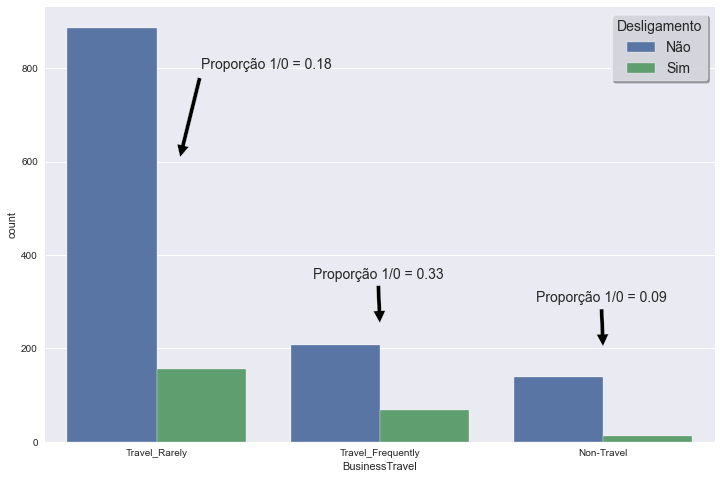

In [40]:
sns.countplot(data= data_cat, x="BusinessTravel", hue="Attrition")
plt.annotate(f'Proporção 1/0 = {round(get_proportion(data, "BusinessTravel", "Attrition")[0], 2)}', xy=(0.1, 600), xytext=(0.2, 800), arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)
plt.annotate(f'Proporção 1/0 = {round(get_proportion(data, "BusinessTravel", "Attrition")[1], 2)}', xy=(1.0, 250), xytext=(0.7, 350), arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)
plt.annotate(f'Proporção 1/0 = {round(get_proportion(data, "BusinessTravel", "Attrition")[2], 2)}', xy=(2.0, 200), xytext=(1.7, 300), arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)
plt.legend(["Não", "Sim"], loc='upper right', fontsize=14, title='Desligamento', title_fontsize=14, frameon=True, framealpha=0.75, edgecolor='white', fancybox=True, shadow=True)
plt.show()

Podemos observar que há uma diferença relevante na proporção dos valores do atributo BusinessTravel, onde que o grupo de pessoas que viajam à negócio com frequência possuem uma chance consideravelmente maior de sair da empresa do que os que não viajam, ou os que viajam raramente.

Talvez um ponto que pode ser interessante de analisar é relacionar as viagens de negócio com as demais variáveis. 

## 4. Preparação dos Dados

### 3.1. Tratando os Atributos Categóricos

Para tratar os atributos categóricos, podemos investigar a natureza de cada atributo categórico. Primeiro, vamos listá-los.

In [41]:
data_categorical = data.select_dtypes(exclude=np.number)
data_categorical.columns

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')

In [42]:
print(f"Valores únicos de cada variável categórica:")
for column in data_categorical.columns.values:
  print(f"{column}: {data_categorical[column].unique().__len__()}")


Valores únicos de cada variável categórica:
BusinessTravel: 3
Department: 3
EducationField: 6
Gender: 2
JobRole: 9
MaritalStatus: 3
Over18: 1
OverTime: 2


Podemos verificar que cada atributo categórico possui um baixo valor de cardinalidade. Tendo um, inclusive, que possui apenas um único valor, que é, no caso, o _Over18_, que pode ser excluído, portanto, da nossa base de dados sem qualquer problema.

In [43]:
try:
  data.drop(columns='Over18')
except:
  pass

Por conta da baixa cardinalidade, talvez uma boa estratégia seja empregarmos o OneHotEncoder. Portanto, teremos

In [44]:
x = data.drop(columns=["Attrition"])
y = data[["Attrition"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=13)

In [45]:
# Definindo o OneHotEncoder
ohe = OneHotEncoder(top_categories=3)

# Treinando o OneHotEncoder
ohe.fit(x_train)

# Transformando os dados
x_train = ohe.transform(x_train)
x_test = ohe.transform(x_test)

## 5. Construindo o Modelo

### 5.1. Treinamento

Inicialmente, escolhemos o classificador LightGBM para construir um modelo para esta base de dados, mas antes de construir o modelo em si, devemos investigar como os dados das classes a serem previstas estão dispostos um em relação ao outro.

In [46]:
print(data['Attrition'].value_counts())

proportion = data['Attrition'].value_counts()[1]/data['Attrition'].value_counts().sum()
print(30*"---")
print(f"\n \nA proporção de funcionários que se desligaram é de: {round(proportion, 2)*100}%")

0    1233
1     237
Name: Attrition, dtype: int64
------------------------------------------------------------------------------------------

 
A proporção de funcionários que se desligaram é de: 16.0%


Como podemos ver, os dados são desbalanceados, pelo fato da classe 0 ser muito mais presente do que a classe 1. Essa informação deve ser levada até o classificador, para que ele possa atribuir o peso adequado para cada classe ao longo do seu treino.

In [47]:
unbalanced_dict = {0: (data['Attrition'].value_counts()[0]/data['Attrition'].value_counts()[1]),
1: (data['Attrition'].value_counts()[1]/data['Attrition'].value_counts()[0])}

lgbm_ = lgb.LGBMClassifier(class_weight=unbalanced_dict, n_estimators=1000, learning_rate=0.05)

lgbm_.fit(x_train, np.ravel(y_train))

LGBMClassifier(class_weight={0: 5.2025316455696204, 1: 0.1922141119221411},
               learning_rate=0.05, n_estimators=1000)

In [48]:
prediction = lgbm_.predict(x_test)
real_value = list(y_test['Attrition'])

In [49]:
print(classification_report(real_value, prediction))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93       248
           1       0.83      0.22      0.34        46

    accuracy                           0.87       294
   macro avg       0.85      0.60      0.64       294
weighted avg       0.87      0.87      0.84       294



Como podemos observar acima, o modelo performar com uma acurácia de 86%, porém possui outras métricas muito baixas, como recall e o f1-score. Talvez uma métrica mais interessante que possamos utilizar pra validar o modelo, seja a auc-score.

In [50]:

auc_score = roc_auc_score(real_value, prediction)
print(f"Probabilidade do modelo identificar corretamente uma das classes: {round(auc_score, 3)*100}%")


Probabilidade do modelo identificar corretamente uma das classes: 60.5%


Podemos obter a matriz de confusão também, que nos dará uma melhor noção de como o modelo está separando cada classe.

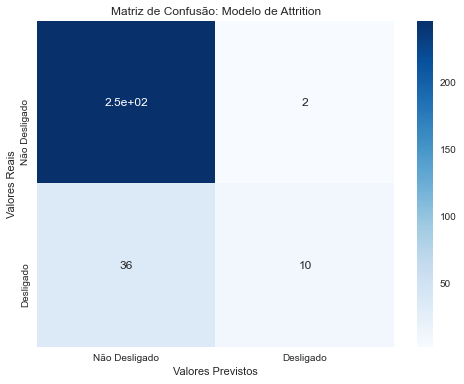

In [51]:
cm = confusion_matrix(real_value, prediction)
fig, ax = plt.subplots(figsize=(8,6))

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Matriz de Confusão: Modelo de Attrition')
ax.set_xlabel('Valores Previstos')
ax.set_ylabel('Valores Reais')

ax.xaxis.set_ticklabels(['Não Desligado', 'Desligado'])
ax.yaxis.set_ticklabels(['Não Desligado', 'Desligado'])

plt.show()

Podemos observar a partir da matriz de confusão, a dificuldade que o modelo tem em identificar os funcionários que foram desligados.

Outra estratégia que podemos abordar é removendo da base de dados os atributos que possuem baixa importância, de acordo com a nossa análise feita no início. Escolhemos, filtrar os atributos que possuem importância abaixo de 1/3 da importância do atributo mais importante.

In [52]:
importance_ratio = (1/3)*features_importance.max()

lesser_important = dict([(x,y) for x,y in zip(features_importance.to_dict().keys(), features_importance.to_dict().values()) if y < importance_ratio])


list_lesser_important = list(lesser_important.keys())
list_lesser_important.append("Attrition")

x_filter = data.drop(columns=list_lesser_important)


In [53]:
x_train_f, x_test_f, y_train_f, y_test_f = train_test_split(x_filter, y, test_size=0.2, random_state=13)

# Definindo o OneHotEncoder
ohe = OneHotEncoder(top_categories=3)
# Treinando o OneHotEncoder
ohe.fit(x_train_f)

# Transformando os dados
x_train_f = ohe.transform(x_train_f)
x_test_f = ohe.transform(x_test_f)


lgbm_filtered = lgb.LGBMClassifier(class_weight=unbalanced_dict, n_estimators=1000, learning_rate=0.05)

lgbm_filtered.fit(x_train_f, np.ravel(y_train_f))

prediction_filtered = lgbm_filtered.predict(x_test_f)

auc_score = roc_auc_score(real_value, prediction_filtered)
print(f"Probabilidade do modelo identificar corretamente uma das classes: {round(auc_score, 3)*100}%")


Probabilidade do modelo identificar corretamente uma das classes: 59.199999999999996%


Verificamos que há uma leve diminuição do auc_score, mas que pode ser compensada por um processamento mais veloz. Podemos verificar a matriz de confusão.

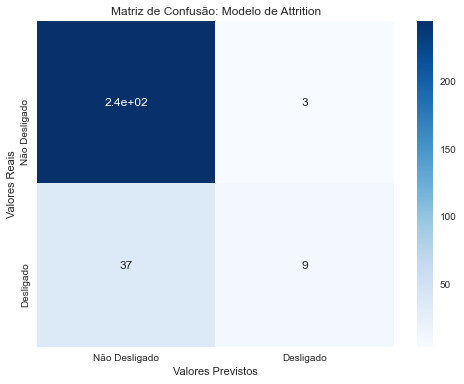

In [54]:
cm = confusion_matrix(real_value, prediction_filtered)
fig, ax = plt.subplots(figsize=(8,6))

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Matriz de Confusão: Modelo de Attrition')
ax.set_xlabel('Valores Previstos')
ax.set_ylabel('Valores Reais')

ax.xaxis.set_ticklabels(['Não Desligado', 'Desligado'])
ax.yaxis.set_ticklabels(['Não Desligado', 'Desligado'])

plt.show()

Verificamos que não há uma diferença real entre a matriz de confusão do modelo com todos os dados e do modelo com os dados filtrados.

In [55]:
print(classification_report(real_value, prediction))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93       248
           1       0.83      0.22      0.34        46

    accuracy                           0.87       294
   macro avg       0.85      0.60      0.64       294
weighted avg       0.87      0.87      0.84       294



Podemos observar que para a métrica de recall e f1-score, o modelo performou muito abaixo do desejado. Isso mostra a deficiência do modelo de avaliar com precisão quando um funcionário se desligou.

### GridSearch

Utilizaremos o GridSearch para ajustar os hiperparâmetros de modo a obter um modelo que maximize a auc_score.

In [56]:
y_train_f = np.ravel(y_train_f)

In [56]:
model_to_search = lgb.LGBMClassifier(class_weight=unbalanced_dict)

params = {'boosting_type': ['gbdt', 'dart'], 
          'num_leaves': [10, 31, 100],
          'max_depth': [-1, 20, 100],
          'learning_rate': [0.01, 0.1, 1],
          'n_estimators': [100, 200, 300]}
          
cross_val = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

grid_search = GridSearchCV(model_to_search,
                           params,
                           scoring='roc_auc',
                           cv=cross_val)





In [57]:
grid_search.fit(x_train_f, y_train_f)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=13, shuffle=True),
             estimator=LGBMClassifier(class_weight={0: 5.2025316455696204,
                                                    1: 0.1922141119221411}),
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [-1, 20, 100],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [10, 31, 100]},
             scoring='roc_auc')

In [58]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'boosting_type': 'dart', 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 10}
0.7683720723127616


Então vamos rodar o lgbm com os melhores parâmetros encontrados pelo GridSearch.

In [59]:
lgbm_best_params = lgb.LGBMClassifier(class_weight=unbalanced_dict, boosting_type=grid_search.best_params_['boosting_type'],
                                      num_leaves=grid_search.best_params_['num_leaves'],
                                      max_depth=grid_search.best_params_['max_depth'],
                                      learning_rate=grid_search.best_params_['learning_rate'],
                                      n_estimators=grid_search.best_params_['n_estimators'],
                                      random_state=13)


lgbm_best_params.fit(x_train_f, y_train_f)

prediction_best_f1 = lgbm_best_params.predict(x_test_f)

auc_score = roc_auc_score(real_value, lgbm_best_params.predict_proba(x_test_f)[:, 1])
print(f"Probabilidade do modelo identificar corretamente uma das classes: {round(auc_score, 3)*100}%")


Probabilidade do modelo identificar corretamente uma das classes: 78.3%


Há uma diferença entre calcular o auc_score para a tabela de probabilidades gerada pelo modelo, e os valores previstos. Isso porque os valores previstos são calculados utilizando o threshold de 50%. Como podemos ver nas diferenças das curvas abaixo

In [60]:
# predict
prediction_best_f1 = lgbm_best_params.predict(x_test_f)

# predict_proba
proba_prediction_best_f1 = lgbm_best_params.predict_proba(x_test_f)[:, 1]

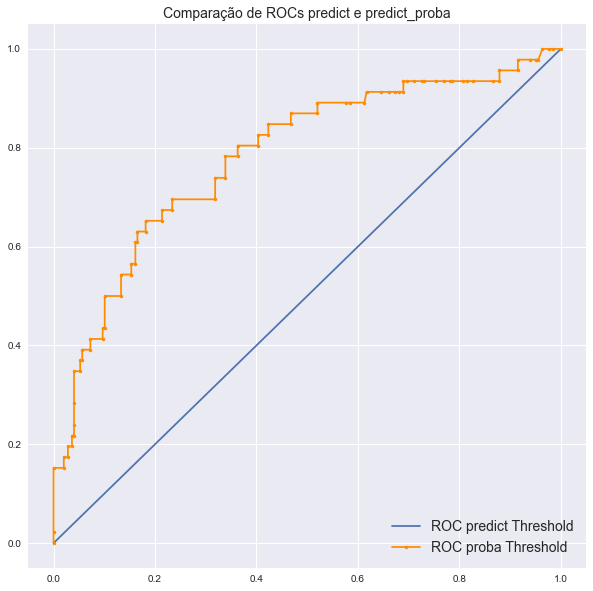

In [61]:

fig, axs = plt.subplots(1,1,figsize=(10,10))


# Curva ROC default
fpr, tpr, thresholds = roc_curve(real_value, prediction_best_f1)
plt.plot(fpr, tpr, label='ROC predict Threshold')


# Curva ROC proba
fpr_proba, tpr_proba, thresholds_proba = roc_curve(real_value, proba_prediction_best_f1)
plt.plot(fpr_proba, tpr_proba, marker='.', color='darkorange', label='ROC proba Threshold')

plt.title("Comparação de ROCs predict e predict_proba", fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.show()

Isso mostra que fixar o threshold como 0.5 talvez não seja a melhor estratégia. Portanto, devemos elaborar uma maneira de escolher de forma mais eficiente qual threshold escolher. Para isso, podemos tirar a média geométrica da sensitividade e especificidade para cada threshold. O threshold que oferecer a maior média, será o escolhido para que adotemos no nosso modelo.

In [62]:
g_means = np.sqrt(tpr_proba*(1-fpr_proba))

lim = np.argmax(g_means)

thresholds_proba[lim]

0.015610016813848684

Com isso, o threshold ótimo seria de aproximadamente 0.4.

In [63]:
proba_prediction = lgbm_best_params.predict_proba(x_test_f)
y_predict = (proba_prediction[:, 1] > round(thresholds_proba[lim], 4)).astype(int)

In [64]:
roc_auc_score(real_value, y_predict)

0.7353611500701263

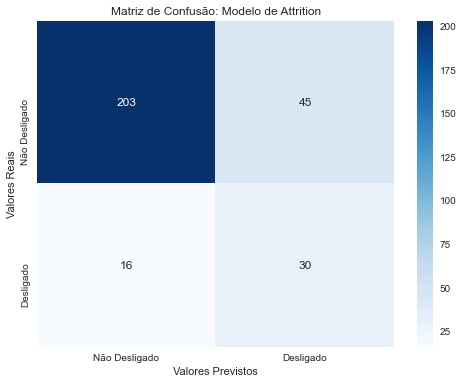

In [65]:
cm = confusion_matrix(real_value, y_predict)
fig, ax = plt.subplots(figsize=(8,6))

ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

ax.set_title('Matriz de Confusão: Modelo de Attrition')
ax.set_xlabel('Valores Previstos')
ax.set_ylabel('Valores Reais')

ax.xaxis.set_ticklabels(['Não Desligado', 'Desligado'])
ax.yaxis.set_ticklabels(['Não Desligado', 'Desligado'])

plt.show()

Como podemos ver, agora o modelo possui uma melhor performance em separar ambas as classes, isso representado tanto pela pontuação da curva roc-auc, quanto pela matriz de confusão acima.

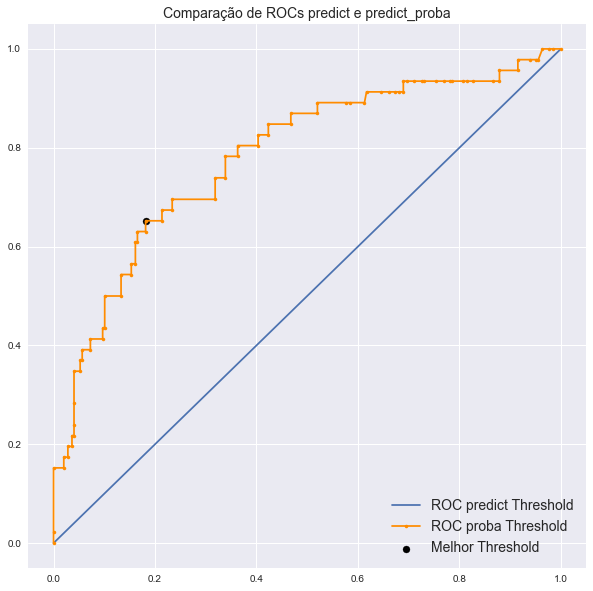

In [66]:
fig, axs = plt.subplots(1,1,figsize=(10,10))


# Curva ROC default
fpr, tpr, thresholds = roc_curve(real_value, prediction_best_f1)
plt.plot(fpr, tpr, label='ROC predict Threshold')


# Curva ROC proba
fpr_proba, tpr_proba, thresholds_proba = roc_curve(real_value, proba_prediction_best_f1)
plt.plot(fpr_proba, tpr_proba, marker='.', color='darkorange', label='ROC proba Threshold')

# Ponto de Melhor Threshold
plt.scatter(fpr_proba[lim], tpr_proba[lim], marker='o', color='black', label='Melhor Threshold')

plt.title("Comparação de ROCs predict e predict_proba", fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.show()

Podemos utilizar uma função que irá funcionar para automatizar esses processos para o futuro.

In [67]:
def best_threshold(valor_real: List[Any], valor_previsto: List[Any]) -> float:
    """
    Função para encontrar o melhor threshold para o modelo.
    """
    fpr, tpr, thresholds = roc_curve(valor_real, valor_previsto)
    g_means = np.sqrt(tpr*(1-fpr))
    lim = np.argmax(g_means)
    return thresholds[lim]


def predict_threshold(valor_previsto: List[Any], threshold: float) -> List[Any]:
    """
    Função para predizer com base no threshold.
    """
    return (valor_previsto > threshold).astype(int)


Outra estratégia que podemos escolher para tentar melhorar a performance do modelo é tentando utilizar ferramentas que balanceam os dados. Aqui iremos tentar três estratégias: uma de undersampling, uma de oversampling, e uma de under-oversampling. 

##### Undersampling: Tomek-Links

Para esse caso, vamos utilizar o undersampling com o método Tomek-Links. Vamos criar uma base de dados balanceada a partir da base de dados original, com a base de dados balanceada, iremos treinar um novo modelo a partir delas. Pelo fato de a base de dados resultante ser completamente diferente da que utilizamos anteriormente, será necessário que os hiperparâmetros sejam ajustados novamente.

Primeiramente, vamos criar balancear a base de dados.

In [68]:
t1 = TomekLinks()

x_t1, y_t1 = t1.fit_resample(x_train_f, y_train_f)

x_train_t1, x_test_t1, y_train_t1, y_test_t1 = train_test_split(x_t1, y_t1, test_size=0.2, random_state=13)

Obtendo os hiperparâmetros para o modelo usando o GridSearch.

In [69]:
model_search_TL = lgb.LGBMClassifier()

params_TL = {'boosting_type': ['gbdt', 'dart'], 
          'num_leaves': [10, 31, 100],
          'max_depth': [-1, 20, 100],
          'learning_rate': [0.01, 0.1, 1],
          'n_estimators': [100, 200, 300]}
          
cross_val_TL = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

grid_search_TL = GridSearchCV(model_search_TL,
                           params,
                           scoring='roc_auc',
                           cv=cross_val_TL)

In [70]:
grid_search_TL.fit(x_train_t1, y_train_t1)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=13, shuffle=True),
             estimator=LGBMClassifier(),
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [-1, 20, 100],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [10, 31, 100]},
             scoring='roc_auc')

In [71]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'boosting_type': 'dart', 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 10}
0.7683720723127616


In [72]:
print(grid_search_TL.best_params_)
print(grid_search_TL.best_score_)

{'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 10}
0.7952347450435855


In [73]:
lgbm_t1 = lgb.LGBMClassifier(boosting_type=grid_search_TL.best_params_['boosting_type'],
                                      num_leaves=grid_search_TL.best_params_['num_leaves'],
                                      max_depth=grid_search_TL.best_params_['max_depth'],
                                      learning_rate=grid_search_TL.best_params_['learning_rate'],
                                      n_estimators=grid_search_TL.best_params_['n_estimators'],
                                      random_state=13)


lgbm_t1.fit(x_train_t1, y_train_t1)
proba_t1 = lgbm_t1.predict_proba(x_test_f)[:, 1]
best_thres = best_threshold(y_test_f, proba_t1)
prediction_t1 = predict_threshold(proba_t1, best_thres)

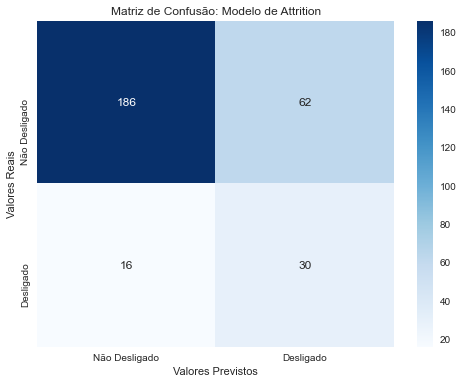

In [74]:
cm = confusion_matrix(y_test, prediction_t1)
fig, ax = plt.subplots(figsize=(8,6))

ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

ax.set_title('Matriz de Confusão: Modelo de Attrition')
ax.set_xlabel('Valores Previstos')
ax.set_ylabel('Valores Reais')

ax.xaxis.set_ticklabels(['Não Desligado', 'Desligado'])
ax.yaxis.set_ticklabels(['Não Desligado', 'Desligado'])

plt.show()

In [75]:
print(classification_report(y_test, prediction_t1))

              precision    recall  f1-score   support

           0       0.92      0.75      0.83       248
           1       0.33      0.65      0.43        46

    accuracy                           0.73       294
   macro avg       0.62      0.70      0.63       294
weighted avg       0.83      0.73      0.77       294



In [76]:
roc_auc_score(y_test_f, prediction_t1)

0.7010869565217391

Podemos verificar tanto pelas métricas de validação quanto pela matriz de confusão, que o modelo treinado com ponderação dos pesos ao longo de cada classificador, e o treinado a partir do uso do tomeklinks são ligeiramente diferentes, sendo o primeiro o que melhor pontuou. Agora testaremos utilizando uma técnica de oversampling usando o SMOTE.

#### Oversampling: SMOTE

In [77]:
# Criando a amostra SMOTE
smote = SMOTE()
x_sm, y_sm = smote.fit_resample(x_train_f, y_train_f)

x_train_sm, x_test_sm, y_train_sm, y_test_sm = train_test_split(x_sm, y_sm, test_size=0.2, random_state=13)

In [78]:
# Executando o GridSearch para o modelo SMOTE
model_search_SM = lgb.LGBMClassifier()

params_SM = {'boosting_type': ['gbdt', 'dart'], 
          'num_leaves': [10, 31, 100],
          'max_depth': [-1, 20, 100],
          'learning_rate': [0.01, 0.1, 1],
          'n_estimators': [100, 200, 300]}
          
cross_val_SM = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

grid_search_SM = GridSearchCV(model_search_SM,
                           params,
                           scoring='roc_auc',
                           cv=cross_val_SM)



grid_search_SM.fit(x_train_sm, y_train_sm)



GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=13, shuffle=True),
             estimator=LGBMClassifier(),
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [-1, 20, 100],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [10, 31, 100]},
             scoring='roc_auc')

In [79]:
print(grid_search_SM.best_params_)
print(grid_search_SM.best_score_)

{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 100}
0.9614961893033692


In [80]:
lgbm_sm = lgb.LGBMClassifier(boosting_type=grid_search_SM.best_params_['boosting_type'],
                                      num_leaves=grid_search_SM.best_params_['num_leaves'],
                                      max_depth=grid_search_SM.best_params_['max_depth'],
                                      learning_rate=grid_search_SM.best_params_['learning_rate'],
                                      n_estimators=grid_search_SM.best_params_['n_estimators'],
                                      random_state=13)


lgbm_sm.fit(x_train_sm, y_train_sm)

prediction_sm = lgbm_sm.predict(x_test_sm)


lgbm_sm.fit(x_train_sm, y_train_sm)
proba_sm = lgbm_sm.predict_proba(x_test_f)[:, 1]
best_thres_sm = best_threshold(y_test_f, proba_sm)
prediction_sm = predict_threshold(proba_sm, best_thres_sm)

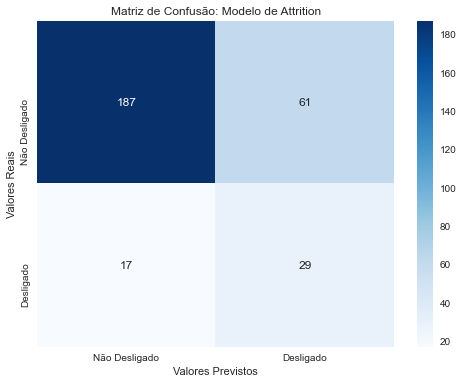

In [81]:
cm = confusion_matrix(y_test_f, prediction_sm)
fig, ax = plt.subplots(figsize=(8,6))

ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

ax.set_title('Matriz de Confusão: Modelo de Attrition')
ax.set_xlabel('Valores Previstos')
ax.set_ylabel('Valores Reais')

ax.xaxis.set_ticklabels(['Não Desligado', 'Desligado'])
ax.yaxis.set_ticklabels(['Não Desligado', 'Desligado'])

plt.show()

In [82]:
print(classification_report(y_test_f, prediction_sm))

              precision    recall  f1-score   support

           0       0.92      0.75      0.83       248
           1       0.32      0.63      0.43        46

    accuracy                           0.73       294
   macro avg       0.62      0.69      0.63       294
weighted avg       0.82      0.73      0.76       294



In [83]:
roc_auc_score(y_test_f, prediction_sm)

0.692233520336606

Podemos ver, no caso do SMOTE, que o roc-auc é ainda menor do que o modelo com o tomeklinks.

#### Under-oversampling: SMOTE-TomekLinks

In [84]:
# Criando a amostra SMOTE-Tomek Links

smt = SMOTETomek(random_state=13)
x_smt, y_smt = smt.fit_resample(x_train_f, y_train_f)

x_train_smt, x_test_smt, y_train_smt, y_test_smt = train_test_split(x_smt, y_smt, test_size=0.2, random_state=13)

In [85]:
# Executando o GridSearch para o modelo SMOTE
model_search_SMT = lgb.LGBMClassifier()

params_SMT = {'boosting_type': ['gbdt', 'dart'], 
          'num_leaves': [10, 31, 100],
          'max_depth': [-1, 20, 100],
          'learning_rate': [0.01, 0.1, 1],
          'n_estimators': [100, 200, 300]}
          
cross_val_SMT = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

grid_search_SMT = GridSearchCV(model_search_SMT,
                           params,
                           scoring='roc_auc',
                           cv=cross_val_SMT)



grid_search_SMT.fit(x_train_smt, y_train_smt)



GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=13, shuffle=True),
             estimator=LGBMClassifier(),
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [-1, 20, 100],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [10, 31, 100]},
             scoring='roc_auc')

In [86]:
print(grid_search_SMT.best_params_)
print(grid_search_SMT.best_score_)

{'boosting_type': 'dart', 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 300, 'num_leaves': 100}
0.9635398317100063


In [93]:
lgbm_smt = lgb.LGBMClassifier(boosting_type=grid_search_SM.best_params_['boosting_type'],
                                      num_leaves=grid_search_SM.best_params_['num_leaves'],
                                      max_depth=grid_search_SM.best_params_['max_depth'],
                                      learning_rate=grid_search_SM.best_params_['learning_rate'],
                                      n_estimators=grid_search_SM.best_params_['n_estimators'],
                                      random_state=13)


lgbm_smt.fit(x_train_smt, y_train_smt)

prediction_smt = lgbm_smt.predict(x_test_smt)


lgbm_smt.fit(x_train_smt, y_train_smt)
proba_smt = lgbm_smt.predict_proba(x_test_f)[:, 1]
best_thres_smt = best_threshold(y_test_f, proba_smt)
prediction_smt = predict_threshold(proba_smt, best_thres_smt)

In [95]:
lgbm_smt.booster_.save_model('modelo_smt.txt')

In [106]:
y_test

,Attrition
634,0
194,0
1404,0
630,0
415,1
...,...
222,0
1022,0
918,0
1324,0


In [110]:
new_lgbm = lgb.LGBMClassifier().fit(x_train_f[:50], y_train_f[:50], init_model='modelo_smt.txt')

test_new = new_lgbm.predict_proba(x_test_f)[:, 1]
best_thres_new = best_threshold(y_test_f, test_new)
prediction_new = predict_threshold(test_new, best_thres_new)

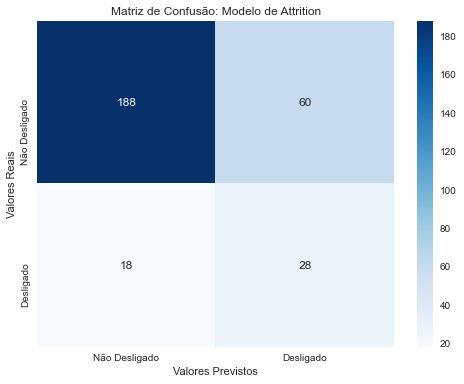

In [88]:
cm = confusion_matrix(y_test_f, prediction_smt)
fig, ax = plt.subplots(figsize=(8,6))

ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

ax.set_title('Matriz de Confusão: Modelo de Attrition')
ax.set_xlabel('Valores Previstos')
ax.set_ylabel('Valores Reais')

ax.xaxis.set_ticklabels(['Não Desligado', 'Desligado'])
ax.yaxis.set_ticklabels(['Não Desligado', 'Desligado'])

plt.show()

In [89]:
print(classification_report(y_test_f, prediction_smt))

              precision    recall  f1-score   support

           0       0.91      0.76      0.83       248
           1       0.32      0.61      0.42        46

    accuracy                           0.73       294
   macro avg       0.62      0.68      0.62       294
weighted avg       0.82      0.73      0.76       294



In [90]:
roc_auc_score(y_test_f, prediction_smt)

0.6833800841514727

Podemos observar que para o caso em que há um under-oversampling, o modelo performa ainda melhor para reconhecer os funcionários que foram desligados, ao preço de piorar consideravelmente a capacidade de reconhecer os funcionários que não forma desligados. Isso ocorre devido ao baixo threshold aplicado nos dados.

In [91]:
print(f'O threshold para o modelo treinado na base under-oversampled é: {round(best_thres_smt, 4)}')

O threshold para o modelo treinado na base under-oversampled é: 0.0598


## Desenhando o Pipeline para este Problema

In [57]:
# Classes Abstratas


class NumericalProcessor(ABC):
  @staticmethod
  @abstractmethod
  def process(self, data: Any):
      pass


class CategoricalProcessor(ABC):
  @staticmethod
  @abstractmethod
  def process(self, data: Any):
    pass

class NaNProcessor(ABC):
  @staticmethod
  @abstractmethod
  def process(self, data: Any):
    pass

class Model(ABC):
  @abstractmethod
  def fit(self, x_train, y_train):
    pass

  @abstractmethod
  def predict(self, x_test, y_test):
    pass

  @abstractmethod
  def predict_proba(self, x_test):
    pass

  @abstractmethod
  def score(self):
    pass

Classes Concretas

In [151]:
# Classes Concretas

class DataAttrition:
  """
  Classe criada para adaptar diversas formatos de arquivos e bases de dados\n
  para ser trabalhada na aplicação.

  Atributos:
  ----------
  data: Pandas DataFrame
    Base de dados a ser trabalhada. Podendo ser recebido a base de dados do pandas,\n
    ou o caminho de um arquivo, sendo possível ler e transformar as seguintes extensões\n
    em dataframe: csv, xlsx, xls, json e parquet.
  """
  def __init__(self, data: pd.DataFrame | Path | str) -> None:
    
    try:
      if isinstance(data, pd.DataFrame):
        self.data_frame = data
      elif isinstance(data, Path):
        self.data_frame = pd.read_csv(data.__str__())
      else:
        df_path_extension = os.path.splitext(data)[-1]
        if df_path_extension == '.csv':
          self.data_frame = pd.read_csv(data)
        elif df_path_extension == '.xlsx' or df_path_extension == '.xls':
          self.data_frame = pd.read_excel(data)
        elif df_path_extension == '.json':
          self.data_frame = pd.read_json(data)
        elif df_path_extension == '.parquet':
          self.data_frame = pd.read_parquet(data)
        else:
          raise ValueError('Extensão de arquivo não suportada.')

    except ValueError as e:
        print('O dado inserido é inválido.', e)


  def train_test_model_data(self, target_variable, test_size=0.2, random_state=0):
    x_train, x_test, y_train, y_test = train_test_split(self.data_frame.drop(columns=target_variable),
    self.data_frame[target_variable], test_size=test_size, random_state=random_state)
    return x_train, x_test, y_train, y_test
        

      
class AttNumProcess(NumericalProcessor):
  """
  Classe criada para trabalhar com dados numéricos.\n
  Atributos:
  ----------
  data: Pandas DataFrame
    Base de dados a ser trabalhada.
  
  """
  def __init__(self, data = None) -> None:
    if data is not None:
      self._data_frame = DataAttrition(data).data_frame.select_dtypes(include=np.number).drop(columns=['Attrition'])

  
  @property
  def data_frame(self) -> pd.DataFrame:
    return self._data_frame

  def process(self, data=None, strategy='standard_scaler') -> pd.DataFrame:
    """
    Método para processar os dados numéricos.\n
    Parâmetros:
    ----------
    data: Pandas DataFrame
      Base de dados a ser trabalhada.
    strategy: str
      Estratégia de normalização.\n
    Opções:
    -------
    standard_scaler: StandardScaler
      Normalização padrão.
    min_max_scaler: MinMaxScaler
      Normalização de escala de 0 a 1.
    robust_scaler: RobustScaler
      Normalização de escala que utiliza estatísticas robustas a outliers.

    """

    #---------------------------------------------------------------#
    # Carrega a base de dados passada como argumento para o cálculo.

    if data is not None:
      self.__init__(data)

    #---------------------------------------------------------------#
    # Estratégias de normalização

    if strategy == 'standard_scaler':
      scaler = StandardScaler()
    elif strategy == 'min_max_scaler':
      scaler = MinMaxScaler()
    elif strategy == 'robust_scaler':
      scaler = RobustScaler()
    else:
      raise ValueError('Não foi possível encontrar a estratégia de normalização.')

    #---------------------------------------------------------------#
    # Normalização dos dados

    self.df_scaled = scaler.fit_transform(self._data_frame)
    self.df_scaled = pd.DataFrame(self.df_scaled, columns=self._data_frame.columns)
    return self.df_scaled



class AttCatProcess(CategoricalProcessor):
  """
  Classe criada para trabalhar com dados categóricos.\n
  Atributos:
  ----------
  data: Pandas DataFrame
    Base de dados a ser trabalhada.

  """

  def __init__(self, data = None) -> None:
    if data is not None:
      self._data_frame = DataAttrition(data).data_frame.select_dtypes(include=['object'])

  @property
  def data_frame(self) -> pd.DataFrame:
    return self._data_frame

  @data_frame.setter
  def set_data_frame(self, data: pd.DataFrame):
    self._data_frame = data
  
  def clean_cat(self, data=None) -> pd.DataFrame:
    """
    Função que exclui variáveis categóricas com dado único.
    Parâmetros:
    ----------
    data: Pandas DataFrame
      Base de dados a ser trabalhada.
    """
    if data is not None:
      self.__init__(data)
    for column in self.data_frame.columns:
      if self.data_frame[column].nunique() == 1:
        self.set_data_frame.drop(column, axis=1, inplace=True)
    return self.data_frame
    
    

  def process(self, data=None, strategy='one_hot') -> pd.DataFrame:
    """
    Método para realizar o encoder dos dados categóricos.\n
    Parâmetros:
    ----------
    data: Pandas DataFrame
      Base de dados a ser trabalhada.
    strategy: str
      Estratégia para a realização do encoder.\n
    Opções:
    -------
    one_hot: OneHotEncoder
      Realiza o encode nos valores das variáveis categóricas transformando-os\n
      em colunas de valores binários.
    label: LabelEncoder
      Realiza o encode nos valores das variáveis categóricas transformando-os\n
      em valores numéricos de 0 a numero_de_valores_da_classe-1.
    count_freq: CountFrequencyEncoder
      Substitui os valores categóricos pela porcentagem de ocorrência dos valores na categoria.
    """

    #---------------------------------------------------------------#
    # Caso um dataset seja passado no argumento, este será carregado na função\n
    # para a realização do cálculo.
    if data is not None:
      self.__init__(data)
    
    #---------------------------------------------------------------#
    # Estratégias de encoder

    # self.clean_cat(self.data_frame)
    if strategy == 'one_hot':
      encoder = OneHotEncoder(drop_last=True)
    elif strategy == 'label':
      encoder = LabelEncoder()
    elif strategy == 'count_freq':
      encoder = CountFrequencyEncoder(encoding_method='frequency')
    else:
      raise ValueError('Não foi possível encontrar a estratégia para realizar o encoder.')

    #---------------------------------------------------------------#
    # Encoder dos dados
    self.df_encoded = encoder.fit_transform(self.data_frame)
    return self.df_encoded
    

#------------------------------------------------------------------------#



#------------------------------------------------------------------------#

class AttNaNProcess(NaNProcessor):
  def __init__(self, data = None) -> None:
    if data is not None:
      self._data_frame = DataAttrition(data).data_frame
    
  @property
  def data_frame(self) -> pd.DataFrame:
    return self._data_frame
  
  @data_frame.setter
  def set_data_frame(self, data: pd.DataFrame):
    self._data_frame = data

  def process(self, data=None, strategy='drop') -> pd.DataFrame:
    """
    Função para processar dados faltantes.
    Parâmetros:
    ----------
    data: Pandas DataFrame
      Base de dados a ser trabalhada.
    strategy: str
      Estratégia para a realização do cálculo.\n
    Opções:
    -------
    drop: Drop
      Exclui as variáveis que contém dados faltantes.
    fill_mean:
      Substitui os dados numéricos faltantes pela média.
    fill_mode: 
      Substitui os dados numéricos faltantes pela moda.
    fill_median:
      Substitui os dados numéricos faltantes pela mediana.
    fill_mode_cat:
      Substitui os dados categóricos faltantes pela moda.

    """

    #---------------------------------------------------------------#
    # Caso um dataset seja passado no argumento, este será carregado na função\n
    # para a realização do cálculo.
    if data is not None:
      self.__init__(data)

    #---------------------------------------------------------------#
    # Separa o dado entre variáveis numéricas e categóricas
    num_data_frame = self.data_frame.select_dtypes(include=np.number).drop(columns='Attrition')
    cat_data_frame = self.data_frame.select_dtypes(include=['object'])

    
    #---------------------------------------------------------------#
    # Estratégias de processamento
    if strategy == 'drop':
      self.set_data_frame.dropna(inplace=True, axis=1)
      return self.data_frame

    elif strategy == 'fill_mean':
      num_data_frame.fillna(self.data_frame.mean(), inplace=True)
      self.set_data_frame[num_data_frame.columns] = num_data_frame
      return self.data_frame


    elif strategy == 'fill_mode':
      num_data_frame.fillna(num_data_frame.mode().iloc[0], inplace=True)
      self.set_data_frame[num_data_frame.columns] = num_data_frame
      return self.data_frame

    elif strategy == 'fill_median':
      self.set_data_frame.fillna(self.data_frame.median(), inplace=True)
      return self.data_frame

    elif strategy == 'fill_mode_cat':
      cat_data_frame.fillna(cat_data_frame.mode().iloc[0], inplace=True)
      self.set_data_frame[cat_data_frame.columns] = cat_data_frame
      return self.data_frame
    else:
      raise ValueError('Não foi possível encontrar a estratégia de imputação.')


#------------------------------------------------------------------------#



#------------------------------------------------------------------------#





class AttModel(Model):
  def __init__(self, model, params=None) -> None:
    self.model = model
    self.prediction = None
    self.prediction_proba = None
    self._target_variable = 'Attrition'
    self._data_importance = None
    self._data_corr = None
    self._corr_importance = None
    if params is not None:
      self.params = params
      self.model.set_params(**self.params)


  @property
  def target_variable(self) -> str:
    return self._target_variable

  @target_variable.setter
  def set_target_variable(self, target_variable: str):
    self._target_variable = target_variable



  @property
  def data_importance(self) -> pd.DataFrame:
    return self._data_importance

  @data_importance.setter
  def set_data_importance(self, data_importance: pd.DataFrame):
    self._data_importance = data_importance

  @property
  def data_corr(self) -> pd.DataFrame:
    return self._data_corr

  @data_corr.setter
  def set_data_corr(self, data_corr: pd.DataFrame):
    self._data_corr = data_corr


  @property
  def corr_importance(self) -> pd.DataFrame:
    return self._corr_importance

  @corr_importance.setter
  def set_corr_importance(self, corr_importance: pd.DataFrame):
    self._corr_importance = corr_importance
  


  def fit(self, x_train: pd.Series | np.ndarray | List[np.number],
   y_train: pd.Series | np.ndarray | List[np.number]) -> None:
    self.model.fit(x_train, y_train)

    

  
  def predict(self, x_test: pd.Series | np.ndarray | List[np.number])-> List[Any]:
    self.prediction = self.model.predict(x_test)
    return self.prediction

  
  def predict_proba(self, x_test: pd.Series | np.ndarray | List[np.number]) -> List[Any]:
    self.prediction_proba = self.model.predict_proba(x_test)
    return self.prediction_proba

  
  def score(self, x_test, y_test, metrics='accuracy'):
    self.predict(x_test)
    if metrics == 'accuracy':
      return self.model.score(x_test, y_test)

    elif metrics == 'roc_auc':
      return roc_auc_score(self.prediction, y_test)

    else:
      raise ValueError('Metrica inserida é inválida.')


  def train_test_data(func):
    def decorator(self, data):
      df = func(self, data)
      df = DataAttrition(df).train_test_model_data(target_variable=self.target_variable)
      return df

    decorator.unwrapped = func
    
    return decorator


  @train_test_data
  def _data_to_clean(self, data):
    df = deepcopy(data)
      
    data_cat_cols = df.select_dtypes(include=['object']).columns

    df[data_cat_cols] = AttCatProcess().process(df, strategy='count_freq')


    return df



  def _feature_analysis(self, data): 
    if self.data_importance is not None:
      return self.data_importance
    
    data_use = self._data_to_clean(data)



    lgb_classifier = lgb.LGBMClassifier()

    lgb_classifier.fit(data_use[0], data_use[2])

    importance = lgb_classifier.feature_importances_


    feat_import = permutation_importance(lgb_classifier, data_use[0], data_use[2], 
    n_repeats=10, random_state=13, n_jobs=-1)
    importance = feat_import.importances_mean
    self.set_data_importance = pd.DataFrame({'feature': data_use[0].columns, 'importance': importance})

    return self.data_importance


  def _correlation_analysis(self, data):

    data = self._data_to_clean.unwrapped(self, data)
    self.set_data_corr = data.corr()[[self.target_variable]].drop(self.target_variable).reset_index().rename(columns={'index': 'feature', self.target_variable: 'correlation'})
    
    # corr_target = corr[self.target_variable]
    # corr_target = corr_target.drop(self.target_variable)

    # self.set_data_corr_importance = pd.concat([self.data_importance, corr], axis=1)
    # return self.data_corr_importance
    return self.data_corr


  def _join_corr_importance(self, data=None):
    if data is not None:
      if self.data_importance is None:
        self._feature_analysis(self.data)
      if self.data_corr is None:
        self._correlation_analysis(self.data)
    else:
      raise ValueError('Insira um dataframe para realizar a análise.')

    self.set_corr_importance = self.data_importance.merge(self.data_corr, on='feature')

    return self.corr_importance



In [61]:
df = deepcopy(data)

df_cols = df.select_dtypes(include=['object']).columns

df[df_cols] = AttCatProcess().process(df, strategy='count_freq')

np.shape(df)

(1470, 36)

In [170]:
np.shape(data)

(1470, 35)

In [152]:
# params = {'boosting_type': ['gbdt', 'dart'], 
#           'num_leaves': [10, 31, 100],
#           'max_depth': [-1, 20, 100],
#           'learning_rate': [0.01, 0.1, 1],
#           'n_estimators': [100, 200, 300]}

params = {'boosting_type': 'gbdt', 
          'num_leaves': 100,
          'max_depth':  100,
          'learning_rate':  0.1,
          'n_estimators':  200}

att_model = AttModel(model=lgb.LGBMClassifier(), params=params)


feat_test_value = att_model._feature_analysis(data=data)

In [153]:
feat_test_value = att_model._feature_analysis(data=data)

In [154]:
feat_test_value

,feature,importance
0,Age,0.010884
1,BusinessTravel,0.000510
2,DailyRate,0.005527
3,Department,0.000000
4,DistanceFromHome,0.002041
5,Education,0.000000
6,EducationField,0.001276
7,EmployeeCount,0.000000
8,EmployeeNumber,0.000255
9,EnvironmentSatisfaction,0.007228


In [155]:
corr_df = att_model._correlation_analysis(data=data)
corr_df

,feature,correlation
0,Age,-0.159205
1,BusinessTravel,-0.038880
2,DailyRate,-0.056652
3,Department,-0.079964
4,DistanceFromHome,0.077924
5,Education,-0.031373
6,EducationField,-0.074756
7,EmployeeCount,NaN
8,EmployeeNumber,-0.010577
9,EnvironmentSatisfaction,-0.103369


In [156]:
att_model._join_corr_importance(data)


,feature,importance,correlation
0,Age,0.010884,-0.159205
1,BusinessTravel,0.000510,-0.038880
2,DailyRate,0.005527,-0.056652
3,Department,0.000000,-0.079964
4,DistanceFromHome,0.002041,0.077924
5,Education,0.000000,-0.031373
6,EducationField,0.001276,-0.074756
7,EmployeeCount,0.000000,NaN
8,EmployeeNumber,0.000255,-0.010577
9,EnvironmentSatisfaction,0.007228,-0.103369


In [205]:
att_model.data_importance

,feature,importance
0,Age,0.006548
1,BusinessTravel,0.000765
2,DailyRate,0.005187
3,Department,0.000000
4,DistanceFromHome,0.003741
5,Education,0.000000
6,EducationField,0.001956
7,EmployeeCount,0.000000
8,EmployeeNumber,0.001616
9,EnvironmentSatisfaction,0.006122


In [197]:
feat_test_value.sort_values(by='importance', ascending=False)

,feature,importance
21,OverTime,0.041922
26,StockOptionLevel,0.016327
17,MonthlyIncome,0.014116
15,JobSatisfaction,0.009864
19,NumCompaniesWorked,0.008418
0,Age,0.006548
9,EnvironmentSatisfaction,0.006122
2,DailyRate,0.005187
33,YearsWithCurrManager,0.003827
4,DistanceFromHome,0.003741


Teste Classes Concretas

In [91]:
att_data = DataAttrition(data=data)

c:\Users\Lucas\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\Users\Lucas\anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,OverTime
0,0.709524,0.303401,0.412245,0.4,0.221769,0.319728,0.282993
1,0.188435,0.653741,0.412245,0.6,0.198639,0.457823,0.717007
2,0.709524,0.653741,0.055782,0.6,0.176190,0.319728,0.282993
3,0.188435,0.653741,0.412245,0.4,0.198639,0.457823,0.282993
4,0.709524,0.653741,0.315646,0.6,0.176190,0.457823,0.717007
...,...,...,...,...,...,...,...
1465,0.188435,0.653741,0.315646,0.6,0.176190,0.457823,0.717007
1466,0.709524,0.653741,0.315646,0.6,0.089116,0.457823,0.717007
1467,0.709524,0.653741,0.412245,0.6,0.098639,0.457823,0.282993
1468,0.188435,0.303401,0.315646,0.6,0.221769,0.457823,0.717007


In [73]:
att_model.fit(x_train_f, y_train_f)

In [74]:
att_model.prediction

In [75]:
att_model.score(x_test_f, y_test_f, metrics='roc_auc')

0.7379562043795621

In [76]:
att_model.model.feature_importances_

array([ 780,    0,  372, 1466,  699,  416,  833,  646,  681,  742,  112,
        143,  133,   53,  192,  172,    9,  277,  186,   75,  196,   84,
        172,  137,  171,  210,  142,   61,    0,  280,   39])

In [78]:
feat_import = permutation_importance(att_model, x_train_f, y_train_f, 
n_repeats=10, random_state=13, n_jobs=-1)

In [82]:
feat_import_mean = list(feat_import.importances_mean)
feat_import_mean

[0.01981292517006804,
 0.0,
 0.05170068027210885,
 0.055272108843537414,
 0.02125850340136055,
 0.014625850340136049,
 0.0125,
 0.009268707482993199,
 0.017602040816326558,
 0.0207482993197279,
 0.0008503401360544282,
 0.0,
 0.001445578231292477,
 0.00501700680272108,
 0.004506802721088421,
 0.0009353741496598511,
 0.0,
 0.001700680272108812,
 0.002976190476190477,
 0.0,
 0.0003401360544217802,
 0.0,
 0.0,
 0.0003401360544217802,
 0.020323129251700666,
 0.0,
 0.0,
 0.0,
 0.0,
 0.06428571428571428,
 0.0]

In [359]:
data.median()

Age                            36.0
Attrition                       0.0
DailyRate                     802.0
DistanceFromHome                7.0
Education                       3.0
EmployeeCount                   1.0
EmployeeNumber               1020.5
EnvironmentSatisfaction         3.0
HourlyRate                     66.0
JobInvolvement                  3.0
JobLevel                        2.0
JobSatisfaction                 3.0
MonthlyIncome                4919.0
MonthlyRate                 14235.5
NumCompaniesWorked              2.0
PercentSalaryHike              14.0
PerformanceRating               3.0
RelationshipSatisfaction        3.0
StandardHours                  80.0
StockOptionLevel                1.0
TotalWorkingYears              10.0
TrainingTimesLastYear           3.0
WorkLifeBalance                 3.0
YearsAtCompany                  5.0
YearsInCurrentRole              3.0
YearsSinceLastPromotion         1.0
YearsWithCurrManager            3.0
WitnessedChangeManager      